In [ ]:
import math

def f(rho: float) -> float:
    """Helper function f(rho)."""
    if rho < -1 or rho > 1:
        raise ValueError("rho must be in [-1, 1]")
    return (1 / math.pi) * (math.sqrt(1 - rho**2) + rho * (math.pi - math.acos(rho)))


def postnorm_update(beta, q, p, alpha_SA, alpha_MLP, sigma_w2, sigma_b2):
    """Post-norm Block Update."""
    beta_c = math.sqrt(2 / (q * (q - p)))
    Y2 = max(0, 1 - beta_c / beta)

    # Attention + residual
    q = p + (q - p) * Y2 + q * (alpha_SA**2)
    p = p * (1 + alpha_SA**2)

    # Post-norm LN
    p = p / q
    q = 1

    # MLP + residual
    q1 = sigma_w2 * q + sigma_b2
    p1 = sigma_w2 * p + sigma_b2

    q2 = (sigma_w2 / 2) * q1 + sigma_b2
    p2 = sigma_w2 /2 * f(p1 / q1) * q1 + sigma_b2

    q = q2 + (alpha_MLP**2) * q
    p = p2 + (alpha_MLP**2) * p

    # Post-norm LN
    p = p / q
    q = 1

    return q, p


def prenorm_update(beta, q, p, alpha_SA, alpha_MLP, sigma_w2, sigma_b2):
    """Pre-norm Block Update."""
    beta_c = math.sqrt(2 / (q * (q - p)))
    Y2 = max(0, 1 - beta_c / beta)

    # Pre-norm LN before attention
    p_LN = p / q
    q_LN = 1

    # Attention + residual
    q = p_LN + (q_LN - p_LN) * Y2 + q * (alpha_SA**2)
    p = p_LN + (alpha_SA**2) * p

    # Pre-norm LN before MLP
    p_LN = p / q
    q_LN = 1

    # MLP + residual
    q1 = sigma_w2 * q_LN + sigma_b2
    p1 = sigma_w2 * p_LN + sigma_b2

    q2 = (sigma_w2 / 2) * q1 + sigma_b2
    p2 = sigma_w2 * f(p1 / q1)/2 * q1 + sigma_b2

    q = q2 + (alpha_MLP**2) * q
    p = p2 + (alpha_MLP**2) * p

    return q, p


def centred_update(beta, q, p, alpha_SA, alpha_MLP, sigma_w2, sigma_b2):
    """Centred Transformer Block Update."""
    beta_c = math.sqrt(2 / (q * (q - p)))
    Y2 = max(0, 1 - beta_c / beta)

    # Attention + residual (centered update)
    q = (alpha_SA**2) * q + (q - p) * Y2 
    p = (alpha_SA**2) * p

    # Post-norm LN
    p = p / q
    q = 1

    # MLP + residual
    q1 = sigma_w2 * q + sigma_b2
    p1 = sigma_w2 * p + sigma_b2

    q2 = (sigma_w2 / 2) * q1 + sigma_b2
    p2 = sigma_w2 * f(p1 / q1) /2 * q1 + sigma_b2

    q = q2 + (alpha_MLP**2) * q
    p = p2 + (alpha_MLP**2) * p

    # Post-norm LN
    p = p / q
    q = 1

    return q, p


def prenorm_centered_update(beta, q, p, alpha_SA, alpha_MLP, sigma_w2, sigma_b2):
    """Pre-norm centered Block Update."""
    beta_c = math.sqrt(2 / (q * (q - p)))
    Y2 = max(0, 1 - beta_c / beta)

    # Pre-norm LN before attention
    p_LN = p / q
    q_LN = 1

    # Attention + residual
    q = (q_LN - p_LN) * Y2 + q * (alpha_SA**2)
    p = (alpha_SA**2) * p

    # Pre-norm LN before MLP
    p_LN = p / q
    q_LN = 1

    # MLP + residual
    q1 = sigma_w2 * q_LN + sigma_b2
    p1 = sigma_w2 * p_LN + sigma_b2

    q2 = (sigma_w2 / 2) * q1 + sigma_b2
    p2 = sigma_w2 * f(p1 / q1)/2 * q1 + sigma_b2

    q = q2 + (alpha_MLP**2) * q
    p = p2 + (alpha_MLP**2) * p

    return q, p

update_fns = {
    "post-LN": postnorm_update,
    "pre-LN": prenorm_update,
    "GC post-LN": centred_update,
    "GC pre-LN": prenorm_centered_update,
}

def experiment(update_fn, beta, L, alpha_SA, alpha_MLP, sigma_w2, sigma_b2):
    """Run experiment for a given variant and parameters."""
    q = 1.0
    p = 0.2
    q_list = [q]
    p_list = [p]
    for _ in range(L):
        if p==q:
            break
        q, p = update_fn(beta, q, p, alpha_SA, alpha_MLP, sigma_w2, sigma_b2)
        q_list.append(q)
        p_list.append(p)
    return q_list, p_list

Running post-LN...
Running pre-LN...
Running GC post-LN...
Running GC pre-LN...


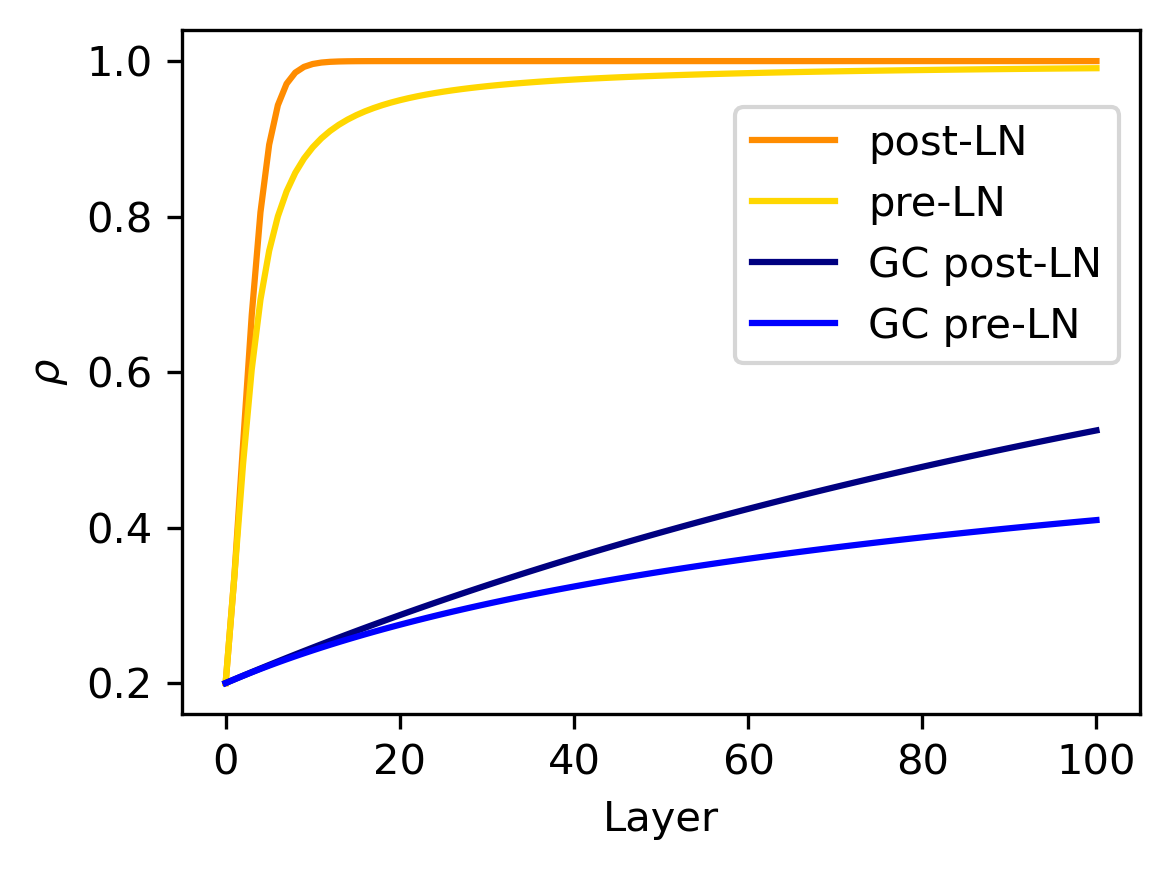

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

sigma_w2 = 0.2
sigma_b2 = 0.02**2
alpha_SA = 1
alpha_MLP = 1
beta = 0.1
L = 100
plt.figure(figsize=(4, 3), dpi=300)

# Define color mapping
color_map = {
    "post-LN": "darkorange",
    "GC post-LN": "navy",
    "pre-LN": "gold",
    "GC pre-LN": "blue"
}

for variant in [
    "post-LN",
    "pre-LN", 
    "GC post-LN", 
    "GC pre-LN"
]:
    print(f"Running {variant}...")
    q_list, p_list = experiment(
        update_fns[variant], beta, L, alpha_SA, alpha_MLP, sigma_w2, sigma_b2
    )
    plt.plot(
        range(len(p_list)),
        np.array(p_list)/np.array(q_list),
        label=variant,
        color=color_map[variant]
    )

plt.xlabel("Layer")
plt.ylabel(r"$\rho $")
plt.legend(loc='center right', bbox_to_anchor=(1, 0.7))
plt.tight_layout()
plt.show()
